# Jupyter Notebook Exploring the Palmer Penguins Data

The Palmer penguins dataset consists of measurements for three penguin species observed on three islands in the Palmer Archipelago, Antarctica. The data was collected over 2007-2009 by Dr. Kristen Gorman with the [Palmer Station Long Term Ecological Research Program](https://pallter.marine.rutgers.edu), part of the [US Long Term Ecological Research Network](https://lternet.edu/).

## Summary Statistics

Before we do anything else, let's import the data into R. There is a `palmerpenguins` package on CRAN. However, here we'll just download the data directly from GitHub.

In [ ]:
penguins <- read.csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/main/inst/extdata/penguins.csv")

Now that the data is loaded into R, let's show some statistical properties of the data using `summary()`.

In [ ]:
summary(penguins)

## Data Cleaning

Before we continue, let's do some simple data cleaning. For this report we're going to ignore any penguins with incomplete data, by removing rows containing an `NA`. For this we'll load the `tidyr` package and use `drop_na()` as a filter.

In [ ]:
webr::install("tidyr")
library(tidyr)

In [ ]:
penguins <- penguins %>% drop_na()

## Data Visualisation and Exploration

The table of results above gives us a good numerical summary of the data, but it looks a little dry. Let's try creating something a little more interesting visually.

### Pairs Plot Visual Summary

We'll create a visual summary using the `pairs()` plotting function. This will create a matrix of scatter plots showing some of the measurements in the dataset plotted against one another. We'll also set the colour of the points using the species of each penguin.

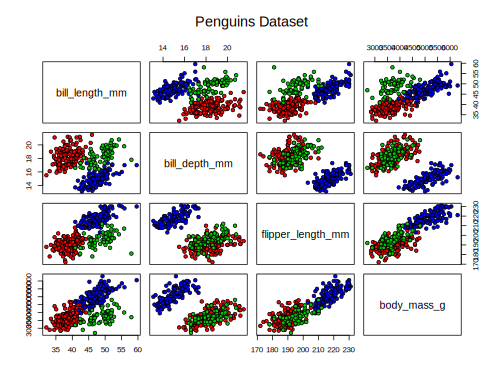

In [ ]:
col <- c("red","green3","blue")
names(col) <- c("Adelie", "Chinstrap", "Gentoo")
pairs(penguins[3:6], main="Penguins Dataset", pch=21, bg=col[penguins$species])

Interesting! There seems to be well defined clusters of penguin species in several of the measured attributes. Let's make some more plots and take a look at the individual measurements in a little more detail.

### Installing Packages

We'll also take the opportunity to switch to using `ggplot2` at this point, too.

In [ ]:
webr::install("ggplot2")
library(ggplot2)

### Penguin Flipper Length Histograms 
Let's create some plots of penguin flipper length in the form of a histogram. We'll use faceting to make several plots at once, so we can see the how the data looks spead over the different species of penguin.

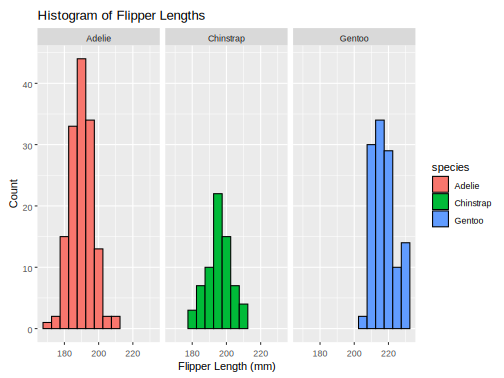

In [ ]:
ggplot(penguins, aes(x=flipper_length_mm, fill=species)) +
  geom_histogram(binwidth=5, color="black") +
  facet_wrap(~species) +
  labs(x="Flipper Length (mm)", y="Count", title="Histogram of Flipper Lengths")

In this dataset it looks like Gentoo penguins might have longer flippers on average than the other species. Let's see if we can formalise something along those lines with a statistical test.

We'll use a one-way ANOVA to test if there is a difference between average flipper length between species of penguin.

In [ ]:
summary(aov(flipper_length_mm ~ species, data = penguins))

             Df Sum Sq Mean Sq F value Pr(>F)    
species       2  50526   25263   567.4 <2e-16 ***
Residuals   330  14693      45                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Indeed, by checking the F statistic in the output of the test it looks likely that there is a significant difference in flipper length between species.

### Bill Length Density Plot

An estimated density plot can be thought as similar to a smoothed histogram. Let's also plot an estimated density of bill length for each of the three species of penguin.


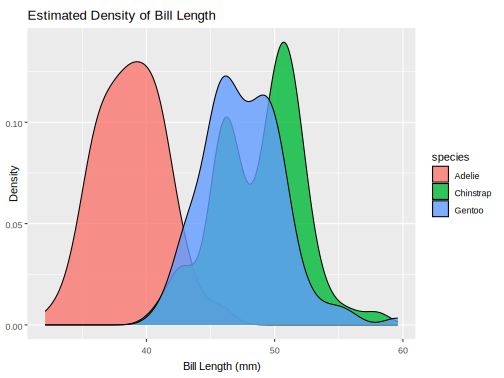

In [ ]:
ggplot(penguins, aes(x=bill_length_mm, fill=species)) +
  geom_density(bw=1, alpha=0.8) +
  labs(x="Bill Length (mm)", y="Density", title="Estimated Density of Bill Length")

In this case it looks like Adelie penguins might have shorter bills on average. Again, let's see if we can confirm this.

This time, in addition to the ANOVA we'll use *Tukey’s Honestly-Significant Difference* test to investigate the pairwise differences in bill length by species.

In [ ]:
bill_length_test = aov(bill_length_mm ~ species, data = penguins)
summary(bill_length_test)

TukeyHSD(bill_length_test)

             Df Sum Sq Mean Sq F value Pr(>F)    
species       2   7015    3508   397.3 <2e-16 ***
Residuals   330   2914       9                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = bill_length_mm ~ species, data = penguins)

$species
                      diff       lwr        upr     p adj
Chinstrap-Adelie 10.009851  8.982789 11.0369128 0.0000000
Gentoo-Adelie     8.744095  7.880135  9.6080546 0.0000000
Gentoo-Chinstrap -1.265756 -2.329197 -0.2023151 0.0148212



From these tests test it looks likely that there is a significant difference in flipper length between species of penguins. In particular, the pairwise differences in bill length between Adelie penguins and the others is largest, confirming what we saw in the kernel density plot.

### Body Mass Box Plots

Box plots can be a very useful visualisation in that they are a quite compact illustration of how data is distributed. We'll now make a box plot showing the distribution of body mass for different sex of penguin.

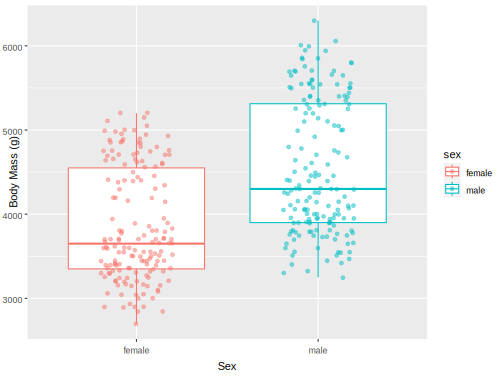

In [ ]:
ggplot(penguins, aes(x=sex, y=body_mass_g)) +
  geom_boxplot(aes(color=sex)) + 
  geom_jitter(aes(color = sex), alpha = 0.5,
              position = position_jitter(width = 0.2, seed = 0)) +
  labs(x="Sex", y="Body Mass (g)")

## Fitting a model using Logistic Regression

Let's pretend a penguin super-fan has seen the plots we made in the previous section. After seeing the clustering in the first pairs plot they suspect that it may be possible to predict the species of a penguin based on measurements of the bill and flippers. They then ask us if we would be able to build a predictive model to find Chinstrap penguins based on the measurements.

Since the outcome variable here is logical, we choose to perform a logistic regression. First, let's split the data into training and validation sets, and create a new indicatior column for Chinstrap penguins.

In [ ]:
set.seed(0)
N <- nrow(penguins)
idx <- sample(1:N, N*2/3)
train <- penguins[idx,]
validation <- penguins[-idx,]

Next, we'll fit a logistic regression (logit) model using R's `glm()` function,

In [ ]:
train$chinstrap = train$species == "Chinstrap"
model <- glm(chinstrap ~ bill_length_mm + bill_depth_mm + body_mass_g + flipper_length_mm,
             data = train, family=binomial(link="logit"))
summary(model)


Call:
glm(formula = chinstrap ~ bill_length_mm + bill_depth_mm + body_mass_g + 
    flipper_length_mm, family = binomial(link = "logit"), data = train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.47908  -0.00083  -0.00001   0.00000   2.03670  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)  
(Intercept)       -31.139438  19.730246  -1.578   0.1145  
bill_length_mm      3.748210   1.761399   2.128   0.0333 *
bill_depth_mm       0.127675   0.579567   0.220   0.8256  
body_mass_g        -0.020364   0.009291  -2.192   0.0284 *
flipper_length_mm  -0.313434   0.188664  -1.661   0.0966 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 236.85  on 221  degrees of freedom
Residual deviance:  11.79  on 217  degrees of freedom
AIC: 21.79

Number of Fisher Scoring iterations: 12



Warning message:
glm.fit: fitted probabilities numerically 0 or 1 occurred


### Assessing Model Predictions

We now have a model that uses penguin measurements to predict if that penguin is a Chinstrap. Let's try it out using our validation set,

In [ ]:
prediction = ifelse(predict(model, validation, type = "response") < 0.5, "Not Chinstrap", "Chinstrap")
table(prediction, validation$species)

               
prediction      Adelie Chinstrap Gentoo
  Chinstrap          1        17      0
  Not Chinstrap     52         1     40


So, it looks like we only misclassified two penguins with this model, giving an accuracy of just over 98%. Nice work!

# Bibliography
 * Horst AM, Hill AP, Gorman KB (2020). palmerpenguins: Palmer Archipelago (Antarctica) penguin data. R package version 0.1.0.
  https://allisonhorst.github.io/palmerpenguins/. doi: 10.5281/zenodo.3960218.